In [1]:
%cd drive/Othercomputers/My Laptop/03_pills

/content/drive/Othercomputers/My Laptop/03_pills


In [2]:
%ls

change_names.py  jpg/        Pills.ipynb     runs/    y.csv
extract_y.py     pills2.pth  pills.pth       test/    y_old.csv
image_gen.gh     pills.3dm   Pills_v2.ipynb  videos/


# **💊💊💊 Pills - A pill counter for my daily vitamin intake 💊💊💊** 
## Hello. In this notebook I created a Convolutional Neural Network model that can predict the number of pills in a picture. The dataset comprised 1,235 images with corresponding labelling of the number of pills that can be seen in the picture. I generated the images from videos (1 per each pill number category). To add variability, in the video I moved the pill container with my hand so to re-arrange the pills in different configurations. The dataset has been split into training and test datasets with a 80/20% ratio. Please note, this is a WIP notebook, and data augementation techniques need to be incorporated, as well as diversification of training samples. In the future I will explore the following:

*   data augmentation (rotating, stretching, cropping)
*   different image backgrounds
*   different lighting conditions
*   different pill containers
*   different pills shapes

## Also, I will embed this into a web-based app so that I can start using it for my morning ritual!



### Following I am importing the required libraries

In [3]:
from glob import glob
from copy import deepcopy
import cv2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.pooling import MaxPool2d
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary
from torchvision.io import read_image, ImageReadMode

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from time import sleep

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

## I am then creating a Dataset class as required by Pytorch. Here I am resizing the images to 180x180pixels and scaling down the values to a range 0 to 1 to allow for easier learning

In [4]:
img_loc = 'jpg/from_videos/'
y = 'y.csv'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class dataset(Dataset):
  def __init__(self, df):
    super(dataset).__init__()
    self.df = df

  def __len__(self): return len(self.df)

  def __getitem__(self, ix):
    img_path = self.df.iloc[ix,0]
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255.
    label = deepcopy(self.df.iloc[ix,1:])[0]
    image = self.preprocess_input(image)
    image = image.resize(1,180,180)
    return image.to(device),torch.tensor(label)
  
  def preprocess_input(self, img):
    im_resized = cv2.resize(img, (180,180))
    im_resized = torch.tensor(im_resized)
    return im_resized.to(device)

### Here I am loading the dataset with image paths and corresponding labels (the number of pills in the image)

In [5]:
y_df = pd.read_csv(y, names=["x", "y"])
y_df

,x,y
0,jpg/from_videos/1_0.jpg,1
1,jpg/from_videos/1_1.jpg,1
2,jpg/from_videos/1_10.jpg,1
3,jpg/from_videos/1_100.jpg,1
4,jpg/from_videos/1_101.jpg,1
...,...,...
1230,jpg/from_videos/9_95.jpg,9
1231,jpg/from_videos/9_96.jpg,9
1232,jpg/from_videos/9_97.jpg,9
1233,jpg/from_videos/9_98.jpg,9


In [6]:
train, test = train_test_split(y_df, test_size=0.2, random_state=101)
train_dataset = dataset(train.reset_index(drop=True))
test_dataset = dataset(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

### Here I am checking an image at random and printing its corresponding label - looks good!

Number of pills:  4


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


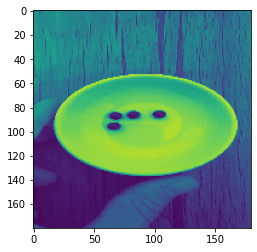

In [7]:
im, label = train_dataset[500]
plt.imshow(im[0,:,:].cpu())
pills_number = label.item()
print('Number of pills: ', pills_number)

### Here I am defining the architecture of the model. It has 4 convolutional layers with MaxPool and a Rectified Linear Activation Function. A flattened layer then is connected to a final layer with the 10 classes (one for each possible number of pills). The widely used CrossEntropyLoss function has been used for the loss calc as I'm training for a discrete categorization inference. Stochastic Gradient Descent has been used via the Adam optimiser.

In [8]:
def get_model():
  model = nn.Sequential(
      nn.Conv2d(1,32,kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(32,64,kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64,128,kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(128,256,kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(20736,100),
      nn.ReLU(),
      nn.Linear(100,10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(),lr = 1e-3)
  return model, loss_fn, optimizer

### The model only accpets 180x180px images with only 1 channel (I turn the images in greyscale as the color of the pill has good contrast against the white container and I can simplify the model having less parameters to optimise. Total number of trainable params is roughly 2.5 MLN

In [9]:
model, loss_fn, optimizer = get_model()
summary(model, (1,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 178, 178]             320
         MaxPool2d-2           [-1, 32, 89, 89]               0
              ReLU-3           [-1, 32, 89, 89]               0
            Conv2d-4           [-1, 64, 87, 87]          18,496
         MaxPool2d-5           [-1, 64, 43, 43]               0
              ReLU-6           [-1, 64, 43, 43]               0
            Conv2d-7          [-1, 128, 41, 41]          73,856
         MaxPool2d-8          [-1, 128, 20, 20]               0
              ReLU-9          [-1, 128, 20, 20]               0
           Conv2d-10          [-1, 256, 18, 18]         295,168
        MaxPool2d-11            [-1, 256, 9, 9]               0
             ReLU-12            [-1, 256, 9, 9]               0
          Flatten-13                [-1, 20736]               0
           Linear-14                  [

### Following are a number of functions that will be called during training or inference:


*   Train the model on the batch data (so prediction > loss calculation > backward pass)
*   Accuray and validation loss calculations (with no_grad() switched on to stop training)
*   Predict function which runs inference for a new test image with no_grad() switched on to stop training

In [10]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x.to(device))
  batch_loss = loss_fn(prediction, y.to(device))
  batch_loss.backward()
  opt.step()
  opt.zero_grad()
  return batch_loss.item()

In [11]:
@torch.no_grad()
def accuracy(x,y,model):
  model.eval()
  prediction = model(x.to(device))
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes ==y.to(device)
  return is_correct.cpu().numpy().tolist()

In [12]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x.to(device))
    val_loss = loss_fn(prediction, y.to(device))
    return val_loss.item()

In [13]:
@torch.no_grad()
def predict(x,model):
  model.eval()
  prediction = model.double()(x.view(1,1,180,180).to(device))
  max_values, argmaxes = prediction.max(-1)
  return prediction, argmaxes

### Here is the training process. I ran 10 epochs and used tqdm to show progress. The training computes both the training batch and the test through the different data loaders.

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(10):
  train_epoch_losses, train_epoch_accuracies = [], []
  with tqdm(train_loader, unit="batch") as tr_epoch:
    for ix, batch in enumerate(iter(tr_epoch)):
      tr_epoch.set_description(f"Train Epoch {epoch}")
      x,y = batch
      batch_loss = train_batch(x,y,model.double(),optimizer,loss_fn)
      train_epoch_losses.append(batch_loss)
      is_correct = accuracy(x, y, model)
      train_epoch_accuracies.extend(is_correct)
      sleep(0.1)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

  with tqdm(test_loader, unit="batch") as te_epoch:
    for ix, batch in enumerate(iter(te_epoch)):
      te_epoch.set_description(f"Test Epoch {epoch}")
      x, y = batch
      val_is_correct = accuracy(x, y, model)
      validation_loss = val_loss(x, y, model)
      sleep(0.1)
    val_epoch_accuracy = np.mean(val_is_correct)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

Test Epoch 9: 100%|██████████| 8/8 [00:08<00:00,  1.09s/batch]


### Training is done. The graphs below show that after only 5 epochs the accuracy for the validation set is nearly 98%

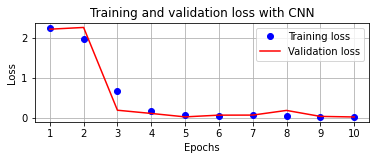

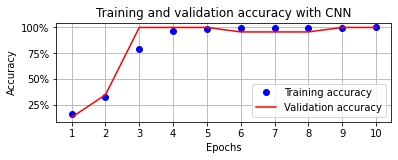

In [ ]:
epochs = np.arange(10)+1

%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

### Here I am saving the model params locally, for future inference

In [ ]:
torch.save(model.to('cpu').state_dict(),'pills2.pth')

### And here I am reloading the model state dict

In [14]:
state_dict = torch.load('pills2.pth')
model.load_state_dict(state_dict)
model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=20736, out_features=100, bias=True)
  (14): ReLU()
  (15): Linear(in_features=100, out_features=10, bias=True)
)

### A quick test showing inference for different test images

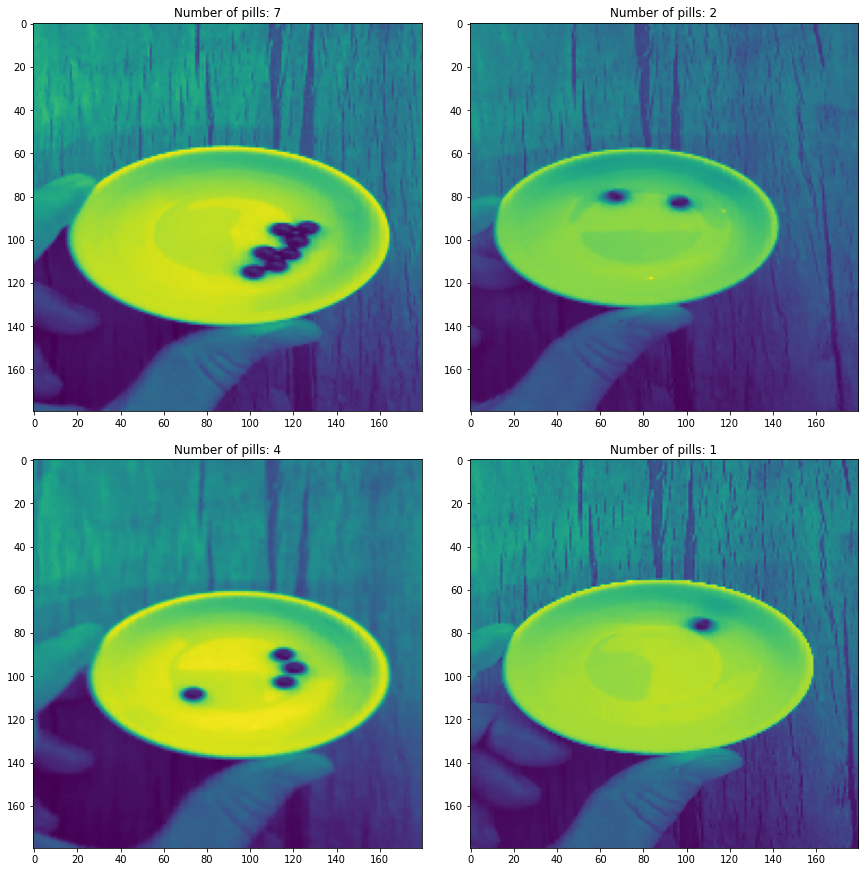

In [37]:
import random

random_test = random.sample(range(0, 220), 4)

fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.set_figheight(12)
fig.set_figwidth(12)
axs = axs.flatten()
for idx, im_idx in enumerate(random_test):
  im, label = test_dataset[idx]
  im = im[0,:,:].cpu()
  prediction = predict(im.cuda(),model)[1][0]
  axs[idx].imshow(im)
  axs[idx].set_title(f'Number of pills: {prediction}')


### Following I am reimporting all images into a numy array

In [ ]:
from PIL import Image
import os

pics = []
directory = 'jpg/from_videos/'
dir = os.listdir(directory)
count = 0
for item in dir:
  # print(item)
  img = cv2.imread(directory+item, cv2.IMREAD_GRAYSCALE)
  im_resized = cv2.resize(img, (180,180))
  pics.append(im_resized)
  count+=1
arr = np.array(pics)
print(arr.shape)

(1235, 180, 180)


### Following I am computing the variance of each pixel across the whole dataset. I want to get a sense of the pixel value variation across the dataset. Clearly, the images are all roughly taken from roughly the same location, as most of the pixels surrounding the white container show little variance. Larger variance values can be seen inside the container where the pills are arranged and also around the edges of the white container. This is because on the edge the pixel color goes from 255 (roughly white) to ~0 (darker colors). This is especially visible on the bottom left quarter of the circular container's edge.

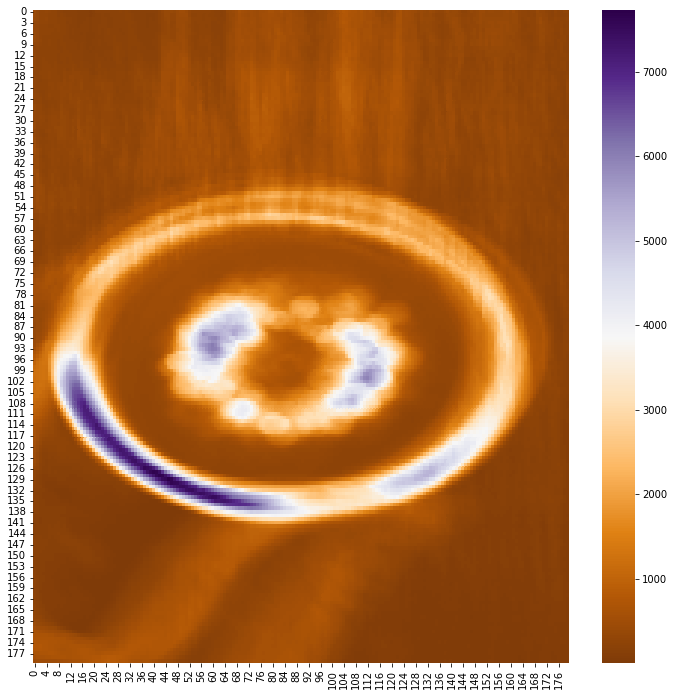

In [ ]:
import seaborn as sns

var = np.var(arr,axis=0)

fig = plt.figure(figsize=(12,12))
sns.heatmap(var, annot=False, cmap='PuOr')
plt.show()

### Finally I'm computing the mean to visualise the average pixel data across the image. Similarly to the variance plot, the below shows that there is little variation across the whole image, suggesting that any image with even a small deviation from this training set will most likely result in an erroneous inference.

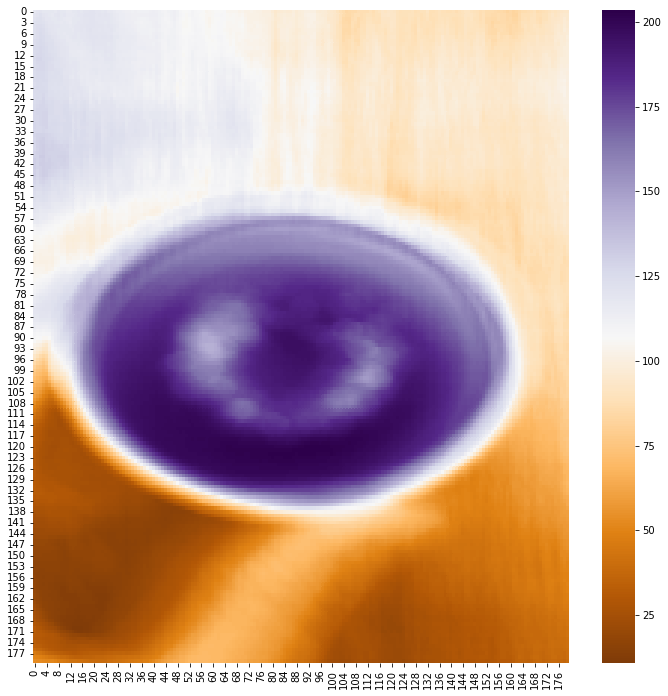

In [ ]:
import seaborn as sns

mean = np.mean(arr,axis=0)

fig = plt.figure(figsize=(12,12))
sns.heatmap(mean, annot=False, cmap='PuOr')
plt.show()